# Анализ тональности текста

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)
print('TensorFlow version:', tf.__version__)

C:\Users\maksi\PycharmProjects\kursach\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.10.0


## Загрузка датасета

In [2]:
dataset = load_dataset('MonoHime/ru_sentiment_dataset')
train_ds = dataset['train']
val_ds   = dataset['validation']
print(train_ds)
print(val_ds)
# Пример записи
print(train_ds[0])

Dataset({
    features: ['Unnamed: 0', 'text', 'sentiment'],
    num_rows: 189891
})
Dataset({
    features: ['Unnamed: 0', 'text', 'sentiment'],
    num_rows: 21098
})
{'Unnamed: 0': 21098, 'text': '.с.,и спросил его:  о Посланник Аллаха!Ты порицаешь что-то из слушания?  Он ответил: я не порицаю ничего из него,но передай им,чтобы они открывали свои собрания Кораном и закрывали их Кораном ...........Это дошедшие до нас мнения и тот кто находится в поисках истины,по мере изучения этого вопроса будет сталкиваться с разногласиями и будет оставаться в растерянности или склонится к мнению одной из сторон по своему желанию.Но всего этого недостаточно,потому что он сам должен найти истину,подробно изучив вопросы запретного и разрешённого.|||||||||||||||||||||||||||||||||||||Обрати внимание:основатели всех четырёх мазхабов осуждали песни и поэззию.И этим часто грешат заблудшие суфии.Исключение делается для исламской тематики  Сахих БухариО проявлении радости во время праздника.498 (949). Сообщ

## Предобработка текста

In [4]:
# Очистка текста (удаляем лишние символы, оставляем базовый набор)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z0-9!,\.\? ]+", " ", text)
    return text.strip()

train_texts = [clean_text(t) for t in train_ds['text']]
val_texts   = [clean_text(t) for t in val_ds['text']]
y_train = np.array(train_ds['sentiment'])
y_val   = np.array(val_ds['sentiment'])
print('Samples:', train_texts[0][:120], '->', y_train[0])

Samples: .с.,и спросил его   о посланник аллаха!ты порицаешь что то из слушания?  он ответил  я не порицаю ничего из него,но пере -> 1


### EDA — разведочный анализ


C:\Users\maksi\AppData\Local\Temp\ipykernel_19564\928389559.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="pastel")


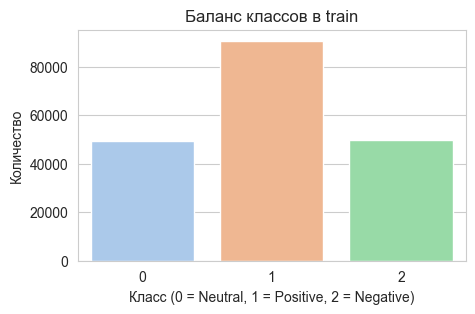

C:\Users\maksi\AppData\Local\Temp\ipykernel_19564\928389559.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp, x="label", y="length", palette="pastel")


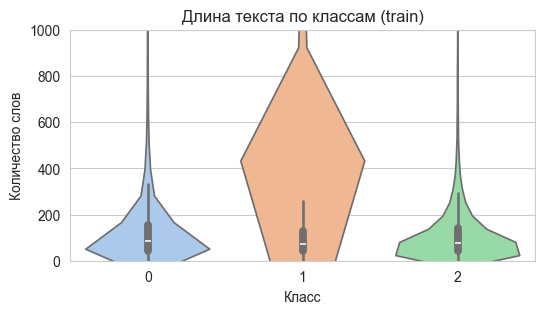

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Баланс классов
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train, palette="pastel")
plt.title("Баланс классов в train")
plt.xlabel("Класс (0 = Neutral, 1 = Positive, 2 = Negative)")
plt.ylabel("Количество")
plt.show()

# Violinplot длины по классам
df_tmp = pd.DataFrame({"length": [len(t.split()) for t in train_texts],
                       "label": y_train})
plt.figure(figsize=(6, 3))
sns.violinplot(data=df_tmp, x="label", y="length", palette="pastel")
plt.ylim(0, 1000)
plt.title("Длина текста по классам (train)")
plt.xlabel("Класс")
plt.ylabel("Количество слов")
plt.show()


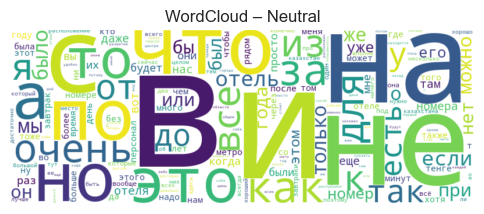

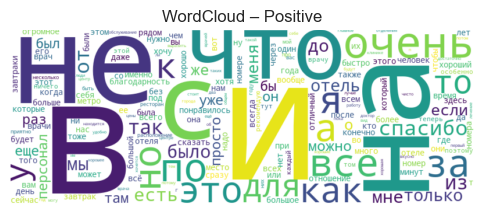

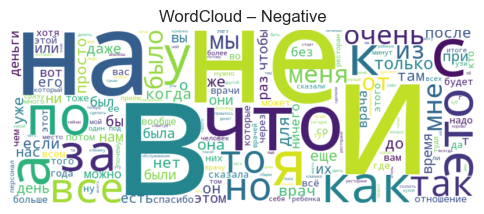

In [6]:
from wordcloud import WordCloud

class_names = ["Neutral","Positive","Negative"]
for cls_id, cls_name in enumerate(class_names):
    texts = " ".join([train_texts[i] for i,v in enumerate(y_train) if v==cls_id])
    wc = WordCloud(width=800, height=300,
                   background_color="white", collocations=False).generate(texts)
    plt.figure(figsize=(6,2.4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud – {cls_name}")
    plt.show()

## Токенизация и паддинг

In [7]:
vocab_size = 20000  # количество наиболее частых слов
max_len = 200       # максимальная длина последовательности
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_val_seq   = tokenizer.texts_to_sequences(val_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post', truncating='post')
print('Padded shape:', X_train_pad.shape)

Padded shape: (189891, 100)


## tf.data Dataset для ускорения ввода

In [22]:
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))\
    .shuffle(buffer_size=len(X_train_pad)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))\
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Функция построения модели

In [23]:
from keras.layers import Bidirectional
from keras import Input


def create_lstm_model(units=128, dropout_rate=0.3, num_layers=1, activation='relu',
                      vocab_size=20000, embed_dim=128):
    model = Sequential()
    model.add(Input(shape=(100,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim))
    if num_layers == 1:
        model.add(Bidirectional(LSTM(units)))
        model.add(Dropout(dropout_rate))
    else:
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(LSTM(units))
        model.add(Dropout(dropout_rate))
    if activation:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

### Базовая модель

In [24]:
base_model = create_lstm_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

## Подбор гиперпараметров (Grid Search, 16 комбинаций)

In [25]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy',
                   patience=5,
                   restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

keras_clf = KerasClassifier(
    model=create_lstm_model,
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    epochs=4,
    batch_size=128,
    verbose=2
)


In [27]:

param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.5],
    'model__num_layers': [1, 2],
    'model__activation': ['relu', None]
}

grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=1)

grid.fit(X_train_pad[:50000], y_train[:50000])
print('Лучшие параметры:', grid.best_params_)
print('Лучшая accuracy на CV:', grid.best_score_)

Epoch 1/4
261/261 - 5s - loss: 0.7529 - accuracy: 0.6371 - 5s/epoch - 20ms/step
Epoch 2/4
261/261 - 4s - loss: 0.4996 - accuracy: 0.7815 - 4s/epoch - 14ms/step
Epoch 3/4
261/261 - 4s - loss: 0.3717 - accuracy: 0.8463 - 4s/epoch - 14ms/step
Epoch 4/4
261/261 - 4s - loss: 0.2606 - accuracy: 0.8988 - 4s/epoch - 13ms/step
131/131 - 1s - 1s/epoch - 9ms/step
Epoch 1/4
261/261 - 6s - loss: 0.7621 - accuracy: 0.6363 - 6s/epoch - 22ms/step
Epoch 2/4
261/261 - 4s - loss: 0.5012 - accuracy: 0.7870 - 4s/epoch - 14ms/step
Epoch 3/4
261/261 - 4s - loss: 0.3755 - accuracy: 0.8468 - 4s/epoch - 14ms/step
Epoch 4/4
261/261 - 4s - loss: 0.2620 - accuracy: 0.8992 - 4s/epoch - 14ms/step
131/131 - 1s - 1s/epoch - 9ms/step
Epoch 1/4
261/261 - 5s - loss: 0.7531 - accuracy: 0.6404 - 5s/epoch - 20ms/step
Epoch 2/4
261/261 - 4s - loss: 0.5026 - accuracy: 0.7828 - 4s/epoch - 14ms/step
Epoch 3/4
261/261 - 4s - loss: 0.3738 - accuracy: 0.8478 - 4s/epoch - 13ms/step
Epoch 4/4
261/261 - 4s - loss: 0.2698 - accuracy: 

In [28]:
# Формируем таблицу из результатов GridSearch
res = pd.DataFrame(grid.cv_results_)
res = res[[
    "param_model__num_layers",
    "param_model__units",
    "param_model__dropout_rate",
    "param_model__activation",
    "mean_test_score",
    "mean_fit_time"
]].copy()

# Переименовываем колонки для читаемости
res.columns = ["Слоёв", "Units", "Dropout", "Активация", "Accuracy", "Время обучения (сек)"]
res["Секунд на эпоху"] = res["Время обучения (сек)"] / 4  # 4 эпохи

# Округляем для аккуратности
res["Accuracy"] = res["Accuracy"].round(4)
res["Секунд на эпоху"] = res["Секунд на эпоху"].round(2)

# Сортировка по времени
res = res.sort_values("Секунд на эпоху").reset_index(drop=True)

# Стилизация: подсвечиваем Accuracy (зеленее = лучше), время (краснее = дольше)
styled = res.style\
    .background_gradient(subset=["Accuracy"], cmap="Greens")\
    .background_gradient(subset=["Секунд на эпоху"], cmap="Reds")\
    .format({"Accuracy": "{:.4f}", "Секунд на эпоху": "{:.2f}"})

display(styled)

,Слоёв,Units,Dropout,Активация,Accuracy,Время обучения (сек),Секунд на эпоху
0,1,64,0.200000,None,0.6904,15.872729,3.97
1,1,64,0.500000,None,0.6920,15.943321,3.99
2,1,64,0.500000,relu,0.6897,16.137363,4.03
3,1,128,0.500000,None,0.6899,16.178694,4.04
4,2,64,0.200000,relu,0.6135,16.202504,4.05
5,2,64,0.200000,None,0.6845,16.333024,4.08
6,1,128,0.200000,None,0.6858,16.344066,4.09
7,2,64,0.500000,None,0.6883,16.344127,4.09
8,1,128,0.200000,relu,0.6878,16.493115,4.12
9,1,64,0.200000,relu,0.6907,16.569916,4.14


## Финальное обучение модели с лучшими гиперпараметрами

In [29]:
best_params = grid.best_params_

best_params = {'activation': best_params['model__activation'], 'dropout_rate': best_params['model__dropout_rate'], 'num_layers': best_params['model__num_layers'], 'units': best_params['model__units']}
final_model = create_lstm_model(**best_params)
history = final_model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[es, reduce_lr])

Epoch 1/10
1484/1484 [==============================] - 25s 16ms/step - loss: 0.6249 - accuracy: 0.7111 - val_loss: 0.5567 - val_accuracy: 0.7405 - lr: 0.0010
Epoch 2/10
1484/1484 [==============================] - 23s 15ms/step - loss: 0.4996 - accuracy: 0.7764 - val_loss: 0.5472 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 3/10
1484/1484 [==============================] - 23s 15ms/step - loss: 0.4289 - accuracy: 0.8133 - val_loss: 0.5648 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 4/10
1483/1484 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8465
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1484/1484 [==============================] - 22s 15ms/step - loss: 0.3630 - accuracy: 0.8465 - val_loss: 0.5931 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 5/10
1484/1484 [==============================] - 22s 15ms/step - loss: 0.2703 - accuracy: 0.8898 - val_loss: 0.6885 - val_accuracy: 0.7467 - lr: 5.0000e-04
Epoch 6/10
1481/1484 [================

## Оценка качества

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

val_loss, val_acc = final_model.evaluate(val_dataset, verbose=0)
print(f'Validation accuracy: {val_acc:.4f}')


labels = ["Neutral", "Positive", "Negative"]
# Предсказания и confusion matrix
y_pred_proba = final_model.predict(X_val_pad, batch_size=512)
y_pred = np.argmax(y_pred_proba, axis=1)
cm = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred, target_names=labels))

fig, ax = plt.subplots(figsize=(4.5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

Validation accuracy: 0.7512
42/42 [==============================] - 1s 7ms/step
Confusion matrix:
 [[3384 1807  369]
 [1206 8349  471]
 [ 649  745 4118]]
              precision    recall  f1-score   support

     Neutral       0.65      0.61      0.63      5560
    Positive       0.77      0.83      0.80     10026
    Negative       0.83      0.75      0.79      5512

    accuracy                           0.75     21098
   macro avg       0.75      0.73      0.74     21098
weighted avg       0.75      0.75      0.75     21098



### Графики обучения

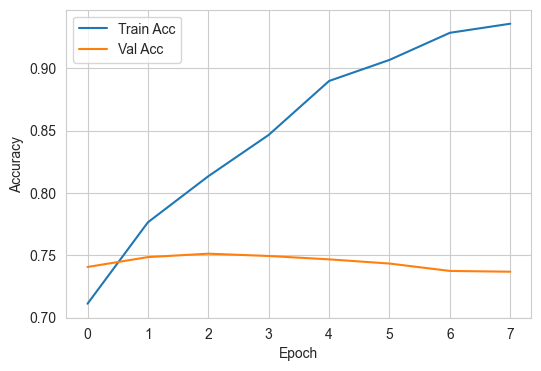

In [31]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Модификация модели

In [33]:
import numpy as np

embedding_index = {}

with open("cc.ru.300.vec", mode='r', encoding="utf-8", newline="\n", errors="ignore") as f:
    next(f)  # пропускаем заголовок
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

In [35]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [36]:
from keras.layers import BatchNormalization

def create_lstm_model_updated(units=128, dropout_rate=0.3, num_layers=1, activation='relu',
                              vocab_size=20000, embed_dim=300):
    model = Sequential()
    model.add(Input(shape=(100,)))
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embed_dim,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=False))  # фиксируем FastText-вектора

    if num_layers == 1:
        model.add(Bidirectional(LSTM(units)))
        model.add(Dropout(dropout_rate))
    else:
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(LSTM(units))
        model.add(Dropout(dropout_rate))

    model.add(BatchNormalization())
    if activation:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model_fasttext = create_lstm_model_updated()
history_ft = model_fasttext.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[es, reduce_lr])

Epoch 1/10
1484/1484 [==============================] - 28s 17ms/step - loss: 0.6776 - accuracy: 0.6723 - val_loss: 0.6366 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 2/10
1484/1484 [==============================] - 24s 16ms/step - loss: 0.5891 - accuracy: 0.7191 - val_loss: 0.5663 - val_accuracy: 0.7313 - lr: 0.0010
Epoch 3/10
1484/1484 [==============================] - 25s 17ms/step - loss: 0.5582 - accuracy: 0.7365 - val_loss: 0.5902 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 4/10
1484/1484 [==============================] - 24s 16ms/step - loss: 0.5369 - accuracy: 0.7483 - val_loss: 0.5461 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 5/10
1484/1484 [==============================] - 23s 16ms/step - loss: 0.5226 - accuracy: 0.7558 - val_loss: 0.5257 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 6/10
1484/1484 [==============================] - 23s 15ms/step - loss: 0.5109 - accuracy: 0.7622 - val_loss: 0.5147 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 7/10
1484/1484 [========================

In [37]:
val_loss, val_acc = model_fasttext.evaluate(val_dataset)
print(f"FastText Accuracy: {val_acc:.4f}")

165/165 [==============================] - 1s 8ms/step - loss: 0.4996 - accuracy: 0.7705
FastText Accuracy: 0.7705


In [38]:
labels = ['Neutral', 'Positive', 'Negative']

y_pred_proba = model_fasttext.predict(X_val_pad, batch_size=512)
y_pred = np.argmax(y_pred_proba, axis=1)
cm = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred, target_names=labels))

fig, ax = plt.subplots(figsize=(4.5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix – FastText модель")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

42/42 [==============================] - 1s 13ms/step
Confusion matrix:
 [[3704 1478  378]
 [1324 8091  611]
 [ 652  398 4462]]
              precision    recall  f1-score   support

     Neutral       0.65      0.67      0.66      5560
    Positive       0.81      0.81      0.81     10026
    Negative       0.82      0.81      0.81      5512

    accuracy                           0.77     21098
   macro avg       0.76      0.76      0.76     21098
weighted avg       0.77      0.77      0.77     21098



### Confusion-matrix Heatmap


In [ ]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Neutral", "Positive", "Negative"]

fig, ax = plt.subplots(figsize=(4.5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix – FastText модель")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

In [33]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    """
    Делает предсказание тональности для одного текстового отзыва.

    Аргументы:
    - text: строка (русский текст отзыва)
    - model: обученная модель Keras
    - tokenizer: объект keras.preprocessing.text.Tokenizer
    - max_len: максимальная длина последовательности (как в обучении)

    Возвращает:
    - Класс (0=нейтральный, 1=позитивный, 2=негативный)
    - Распределение вероятностей по классам
    """
    # Предобработка текста
    def clean_text(t):
        t = t.lower()
        t = re.sub(r"[^а-яёa-z0-9!,\\.\\? ]+", " ", t)
        return t.strip()

    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Предсказание
    proba = model.predict(padded)[0]
    predicted_class = int(np.argmax(proba))

    # Интерпретация
    class_names = {0: "Нейтральный", 1: "Позитивный", 2: "Негативный"}
    print(f"📝 Текст: {text[:60]}...")
    print(f"🔍 Предсказано: {class_names[predicted_class]} (класс {predicted_class})")
    print(f"📊 Вероятности: {np.round(proba, 3)}")

    return predicted_class, proba

sample_text = "Очень понравился сервис! Хорошие продавцы!"
predict_sentiment(sample_text, final_model, tokenizer)

1/1 [==============================] - 0s 19ms/step
📝 Текст: Очень понравился сервис! Хорошие продавцы!...
🔍 Предсказано: Позитивный (класс 1)
📊 Вероятности: [0.112 0.888 0.001]


(1, array([1.1158843e-01, 8.8753122e-01, 8.8028383e-04], dtype=float32))